# <center><b>mdapy</b>: Molecular dynamics simulation analysis with Python</center>

<center><img src="https://img.pterclub.com/images/2023/01/06/logo.png" alt="logo.png" border="0" width="500"/></center>

#### <center> <b>Author</b>：Yong-Chao Wu </center>
#### <center> <b>Supervisor</b>: Jian-Li Shao</center>
#### <center> <b>Date</b>: 2023/10/20</center>
- Wu, Y. C., & Shao, J. L. (2023). mdapy: A flexible and efficient analysis software for molecular dynamics simulations. Computer Physics Communications, 290, 108764. https://doi.org/10.1016/j.cpc.2023.108764

# <b>Tutorial for Beginners</b>

## <b>1. 适用范围</b>
- 主要面向固体材料的模拟，特别是金属/合金体系
- 适合于单一Frame的系统状态分析，而不是一个轨迹中不同Frame间的关联分析
- 直接支持LAMMPS中的dump和data文件格式
- 仅支持三维构型
- 具有很好的文件读写性能，良好的计算性能

## <b>2. 安装</b>

- conda create -n mda
- conda activate mda
- pip install mdapy -U

## <b>3. 使用流程</b>

<img src="https://img.pterclub.com/images/2023/09/22/workflow.png" alt="workflow.png" border="0" width="800"/>

- 导入需要的库

In [1]:
import mdapy as mp
import numpy as np
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
mp.init()

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.0


[Taichi] Starting on arch=x64


- 查看mdapy版本

In [2]:
mp.__version__

'0.9.5'

## <b> 4. System Class </b>

mdapy中一个核心的结构是*System*类，这个类由原子的Position, Box和Boundary组成
- 生成System类的第一种方式，直接读取一个Dump/Data文件

In [3]:
system = mp.System('./frame/CoCuFeNiPd.dump')

- 查看system实例包含的信息

In [4]:
system

Filename: ./frame/CoCuFeNiPd.dump
Atom Number: 8788
Simulation Box:
[[47.36159615  0.          0.        ]
 [ 0.         47.46541884  0.        ]
 [ 0.          0.         47.46849764]
 [-1.18079807 -1.23270942 -1.23424882]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (5, 5)
┌─────┬──────┬───────────┬───────────┬───────────┐
│ id  ┆ type ┆ x         ┆ y         ┆ z         │
│ --- ┆ ---  ┆ ---       ┆ ---       ┆ ---       │
│ i64 ┆ i64  ┆ f64       ┆ f64       ┆ f64       │
╞═════╪══════╪═══════════╪═══════════╪═══════════╡
│ 1   ┆ 2    ┆ 0.006118  ┆ -0.310917 ┆ -0.345241 │
│ 2   ┆ 4    ┆ 1.9019    ┆ -0.292456 ┆ 1.48488   │
│ 3   ┆ 3    ┆ -0.015641 ┆ 1.58432   ┆ 1.43129   │
│ 4   ┆ 5    ┆ 1.86237   ┆ 1.51117   ┆ -0.372278 │
│ 5   ┆ 5    ┆ 3.79257   ┆ -0.331891 ┆ -0.37583  │
└─────┴──────┴───────────┴───────────┴───────────┘

- 查看Box信息
1. mdapy中的盒子是一个(4x3)的2维数组，前三行代表盒子的三个基向量，最后一行是盒子的原点
2. 盒子采用LAMMPS的规则，所以box[0, 1]==box[0, 2]==box[1, 2]==0
3. 对于正交盒子，为了和之前版本的兼容性，mdapy也支持(3x2)的盒子，第一列代表[xlo, ylo, zlo],第二列代表[xhi, yhi, zhi]

In [5]:
system.box

array([[47.36159615,  0.        ,  0.        ],
       [ 0.        , 47.46541884,  0.        ],
       [ 0.        ,  0.        , 47.46849764],
       [-1.18079807, -1.23270942, -1.23424882]])

- 查看原子Position信息
- (Nx3)的2维数组,分别代表x, y, z坐标

In [6]:
system.pos

array([[ 6.11791e-03, -3.10917e-01, -3.45241e-01],
       [ 1.90190e+00, -2.92456e-01,  1.48488e+00],
       [-1.56413e-02,  1.58432e+00,  1.43129e+00],
       ...,
       [ 4.53771e+01,  4.37577e+01,  4.52727e+01],
       [ 4.34552e+01,  4.54854e+01,  4.52825e+01],
       [ 4.53919e+01,  4.54009e+01,  4.34999e+01]])

- 查看边界Boundary信息
- 是一个包含三个数字的列表，其中1代表周期性边界，0代表自由边界

In [7]:
system.boundary

[1, 1, 1]

- 查看所有Particle相关的数据
- 存储为polars.DataFrame的格式

In [8]:
system.data

id,type,x,y,z
i64,i64,f64,f64,f64
1,2,0.006118,-0.310917,-0.345241
2,4,1.9019,-0.292456,1.48488
3,3,-0.015641,1.58432,1.43129
4,5,1.86237,1.51117,-0.372278
5,5,3.79257,-0.331891,-0.37583
7,2,3.81982,1.51825,1.45498
53,1,-0.015263,3.35832,-0.438609
54,3,1.85124,3.33194,1.37874
57,3,3.80567,3.23906,-0.392132


## <b> 5. Neighbor information </b>

### <b> 5.1 截断半径内的邻域 </b>
- 使用元胞链表算法建立邻域

In [9]:
system.build_neighbor(rc=5., max_neigh=60)

- 查看原子的邻域列表
1. 是一个(N, max_neigh)的2维数组，每一行对应该原子的邻域内原子索引
2. max_neigh代表最大邻域原子数目，可以手动指定，也可以自动生成
3. 手动指定可以节约内存，提高计算速度

In [10]:
system.verlet_list

array([[8787, 8786, 8785, ...,   -1,   -1,   -1],
       [8683, 8678, 7785, ...,   -1,   -1,   -1],
       [8683, 8678, 7890, ...,   -1,   -1,   -1],
       ...,
       [8787, 8786, 8784, ...,   -1,   -1,   -1],
       [8787, 8785, 8784, ...,   -1,   -1,   -1],
       [8786, 8785, 8784, ...,   -1,   -1,   -1]])

- 查看原子的邻域距离列表
- 与verlet_list相对应的欧式距离，考虑了周期性边界

In [11]:
system.distance_list

array([[4.48415851, 4.63487321, 4.35033004, ..., 6.        , 6.        ,
        6.        ],
       [4.46090018, 4.58191893, 4.52604475, ..., 6.        , 6.        ,
        6.        ],
       [4.31507754, 4.44738973, 4.59567837, ..., 6.        , 6.        ,
        6.        ],
       ...,
       [2.41725984, 2.5843264 , 2.54077073, ..., 6.        , 6.        ,
        6.        ],
       [2.63355461, 2.5843264 , 2.4206412 , ..., 6.        , 6.        ,
        6.        ],
       [2.63355461, 2.41725984, 2.55379803, ..., 6.        , 6.        ,
        6.        ]])

- 查看原子的邻域原子数目

In [12]:
system.neighbor_number

array([43, 44, 42, ..., 44, 44, 43])

- 获取0号原子的近邻列表

In [13]:
system.verlet_list[0][system.verlet_list[0]>-1]

array([8787, 8786, 8785, 8683, 8678, 8677, 8676, 7890, 7887, 7886, 7885,
       7785, 7782, 7779, 7778, 7777, 7776, 1012, 1010, 1009, 1008,  902,
        901,  899,  897,  896,  895,  894,  115,  113,  111,  110,  109,
        108,   10,    9,    7,    6,    5,    4,    3,    2,    1])

- 对应的距离

In [14]:
system.distance_list[0][system.distance_list[0]<=system.rc]

array([4.48415851, 4.63487321, 4.35033004, 4.32684219, 2.57315649,
       4.56321812, 4.28528359, 4.59095276, 4.66010003, 4.75302553,
       2.75477768, 4.39168451, 4.61796939, 2.72325674, 4.72094208,
       2.60048836, 3.89905069, 4.59982507, 4.55429545, 2.58034816,
       4.3158718 , 4.39625655, 4.94515661, 4.54723002, 2.57907233,
       2.51207599, 4.33703698, 3.40006632, 4.52692755, 4.59187976,
       4.58003255, 2.63799722, 2.64905416, 3.73204205, 4.42655427,
       3.47691914, 4.43249288, 3.67048701, 4.59684361, 3.78663373,
       2.60123122, 2.59777966, 2.63508509])

- 计算距离来验证

In [15]:
system.atom_distance(0, 8787)

4.484158107630933

### <b> 5.2 固定数目的最近邻查找 </b>
- 使用Kdtree来建立最近邻列表

In [16]:
kdt = mp.NearestNeighbor(system.pos, system.box, system.boundary)

In [17]:
distance_list, verlet_list = kdt.query_nearest_neighbors(12)

- 查看最近邻信息

In [18]:
verlet_list[0]

array([ 896, 8678,  897, 1009,    2, 7777,    3,    1,  110,  109, 7779,
       7885], dtype=int64)

In [19]:
distance_list[0]

array([2.51207536, 2.57315662, 2.5790717 , 2.58034708, 2.59777966,
       2.60048908, 2.60123122, 2.63508509, 2.63799678, 2.64905374,
       2.72325745, 2.75477797])

## <b> 6. 后处理分析 </b>

#### 6.1 计算径向分布函数

In [20]:
system.cal_pair_distribution()

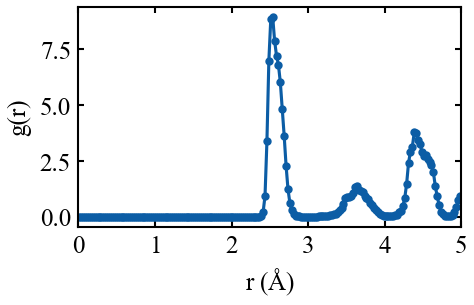

In [21]:
fig, ax = system.PairDistribution.plot()

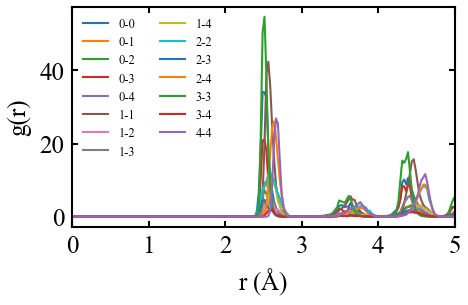

In [22]:
fig, ax = system.PairDistribution.plot_partial()

#### 6.2 计算WCP参数

In [23]:
system.cal_warren_cowley_parameter()

In [24]:
system.WarrenCowleyParameter.WCP

array([[-1.39078011,  0.63941399,  0.39269725, -0.30498922,  0.66252684],
       [ 0.63941399, -1.93830149,  0.58034431,  0.51486949,  0.20332652],
       [ 0.3929276 ,  0.58050349, -0.56415998,  0.63267377, -1.04016883],
       [-0.30492733,  0.51489249,  0.63255182, -1.69477812,  0.85080842],
       [ 0.66254282,  0.20336424, -1.04084631,  0.8508084 , -0.67471711]])

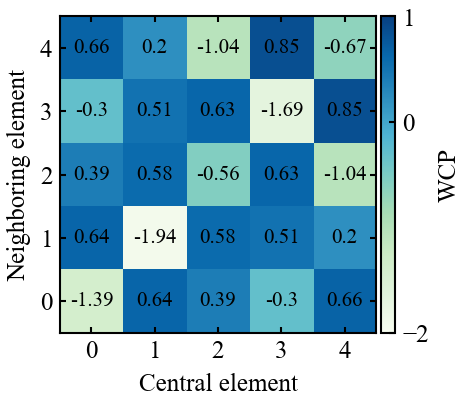

In [25]:
fig, ax = system.WarrenCowleyParameter.plot()

#### 6.3 PTM结构分析

In [26]:
system.cal_polyhedral_template_matching()

#### 6.4 计算中心对称参数

In [27]:
system.cal_centro_symmetry_parameter()

#### 6.5 计算构型熵

In [28]:
system.cal_atomic_entropy(rc=3.6*1.4, compute_average=True, average_rc=3.6*0.9)

#### 6.6 计算Voronoi体积

In [29]:
system.cal_voronoi_volume()

#### 查看计算结果

In [30]:
system.data.head()

id,type,x,y,z,structure_types,csp,atomic_entropy,ave_atomic_entropy,voronoi_volume,voronoi_number,cavity_radius
i64,i64,f64,f64,f64,i32,f64,f64,f64,f64,i32,f64
1,2,0.006118,-0.310917,-0.345241,1,0.100696,-5.997982,-6.469181,12.68101,15,3.675684
2,4,1.9019,-0.292456,1.48488,1,0.139543,-6.640986,-6.677864,12.012947,14,3.581766
3,3,-0.015641,1.58432,1.43129,1,0.094929,-6.821842,-6.666716,12.197214,12,3.674408
4,5,1.86237,1.51117,-0.372278,1,0.072999,-6.95832,-6.940528,12.900968,15,3.713117
5,5,3.79257,-0.331891,-0.37583,1,0.046358,-6.679067,-6.846047,12.400861,14,3.645415


#### 保存结果到新的dump/data文件

In [31]:
system.write_dump()

#### 6.7 使用Bond order判断是solid还是liquid
- 这里重新读取一个固液共存的dump文件

In [32]:
system = mp.System('frame/solidliquid.dump') # 钼（Molybdenum） 2896 K

In [33]:
system.cal_steinhardt_bond_orientation(solidliquid=True)

#### 6.8 计算原子平均温度

In [34]:
system.cal_atomic_temperature(np.array([system.data['mass'][0]]))

In [35]:
print(f"Average temperature is {system.data['atomic_temp'].mean()} K")

Average temperature is 2672.1226208867897 K


In [36]:
system.data.head()

id,type,mass,x,y,z,vx,vy,vz,ql6,solidliquid,atomic_temp
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64
7913,1,95.94,2.64108,3.2152,1.74197,2.90096,1.72875,-1.77975,0.338703,0,2234.23725
4098,1,95.94,-0.091857,0.4658,0.936675,-0.166803,0.959803,3.70312,0.503473,0,2610.685635
4414,1,95.94,51.3076,2.93742,2.12484,4.50605,-1.06924,-1.41931,0.411614,0,2192.303592
4,1,95.94,3.57773,-0.024408,2.31072,-6.04709,5.23451,9.18538,0.304366,0,2351.47728
37,1,95.94,45.219,19.5654,-0.241386,-5.20306,3.79694,-2.15249,0.567507,0,2911.470647


In [37]:
system.write_dump()

#### 6.9 识别FCC基体中的ISF,ESF,TW, HCP
- 这里读取一个包含多种缺陷的dump文件

In [38]:
system = mp.System('frame/ISF.dump')

In [39]:
system.cal_identify_SFs_TBs()

In [40]:
system.write_dump()

#### 对于斜盒子体系依然适用
- 这里读取一个HCP的Ti体系

In [41]:
Ti = mp.System('./frame/Ti.data')

In [42]:
Ti

Filename: ./frame/Ti.data
Atom Number: 2
Simulation Box:
[[ 2.93573192  0.          0.        ]
 [-1.46786596  2.54241842  0.        ]
 [ 0.          0.          4.64085615]
 [ 0.          0.          0.        ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (2, 5)
┌─────┬──────┬────────────┬──────────┬──────────┐
│ id  ┆ type ┆ x          ┆ y        ┆ z        │
│ --- ┆ ---  ┆ ---        ┆ ---      ┆ ---      │
│ i64 ┆ i64  ┆ f64        ┆ f64      ┆ f64      │
╞═════╪══════╪════════════╪══════════╪══════════╡
│ 1   ┆ 1    ┆ -1.4679e-8 ┆ 1.694946 ┆ 1.160214 │
│ 2   ┆ 1    ┆ 1.467866   ┆ 0.847473 ┆ 3.480642 │
└─────┴──────┴────────────┴──────────┴──────────┘

In [43]:
Ti.cal_common_neighbor_analysis(rc=2.9357*1.207)

In [44]:
Ti.cal_centro_symmetry_parameter()

In [45]:
Ti.data

id,type,x,y,z,cna,csp
i64,i64,f64,f64,f64,i32,f64
1,1,-1.4679e-8,1.694946,1.160214,2,8.618522
2,1,1.467866,0.847473,3.480642,2,8.618522


In [46]:
Ti.write_dump()

## <b> 7. 建立初始模型 </b>

#### 7.1 建立简单模型 FCC, BCC, HCP, Graphene

In [47]:
fcc = mp.LatticeMaker(3.615, 'FCC', 10, 10, 10)
fcc.compute()

In [48]:
fcc.box

array([[36.15,  0.  ,  0.  ],
       [ 0.  , 36.15,  0.  ],
       [ 0.  ,  0.  , 36.15],
       [ 0.  ,  0.  ,  0.  ]])

In [49]:
fcc.pos

array([[ 0.    ,  0.    ,  0.    ],
       [ 1.8075,  1.8075,  0.    ],
       [ 1.8075,  0.    ,  1.8075],
       ...,
       [34.3425, 34.3425, 32.535 ],
       [34.3425, 32.535 , 34.3425],
       [32.535 , 34.3425, 34.3425]])

保存为data/dump文件

In [50]:
fcc.write_data(output_name='./frame/fcc.data')

对于FCC和BCC晶体可以指定初始晶向

In [51]:
fcc_111 = mp.LatticeMaker(3.615, 'FCC', 10, 10, 10, crystalline_orientation=np.array([[1,1,1], [1,-1,0], [1,1,-2]]))
fcc_111.compute()

In [52]:
fcc_111.write_dump(output_name='./frame/fcc_111.dump')

- 测试一下大体系的计算效率
- 生成400w原子体系

In [53]:
repli = mp.Replicate(fcc.pos, fcc.box, 10, 10, 10)
repli.compute()

- 建立0.5nm邻域

In [54]:
%%time
neigh = mp.Neighbor(repli.pos, repli.box, 5., max_neigh=50)
neigh.compute()

CPU times: total: 24.8 s
Wall time: 3.53 s


- 手动排序获取最近邻

In [55]:
%%time
neigh.sort_verlet_by_distance(12)

CPU times: total: 11.5 s
Wall time: 393 ms


In [56]:
neigh.verlet_list[0][:12]

array([      3,       2,       1, 3603602, 3603601,  360363,  360361,
         36039,   36038, 3639638,  396399, 3963961])

In [57]:
neigh.distance_list[0][:12]

array([2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101])

- 搜索12个最近邻

In [58]:
%%time
kdt = mp.NearestNeighbor(repli.pos, repli.box)
dis, verlet = kdt.query_nearest_neighbors(12)

CPU times: total: 42.9 s
Wall time: 3.72 s


In [59]:
dis[0]

array([2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101])

In [60]:
verlet_list[0]

array([ 896, 8678,  897, 1009,    2, 7777,    3,    1,  110,  109, 7779,
       7885], dtype=int64)

#### 使用Position和Box建立System

In [61]:
newsystem = mp.System(pos=fcc.pos, box=fcc.box)

In [62]:
newsystem

Filename: None
Atom Number: 4000
Simulation Box:
[[36.15  0.    0.  ]
 [ 0.   36.15  0.  ]
 [ 0.    0.   36.15]
 [ 0.    0.    0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (5, 5)
┌─────┬──────┬────────┬────────┬────────┐
│ id  ┆ type ┆ x      ┆ y      ┆ z      │
│ --- ┆ ---  ┆ ---    ┆ ---    ┆ ---    │
│ i32 ┆ i32  ┆ f64    ┆ f64    ┆ f64    │
╞═════╪══════╪════════╪════════╪════════╡
│ 1   ┆ 1    ┆ 0.0    ┆ 0.0    ┆ 0.0    │
│ 2   ┆ 1    ┆ 1.8075 ┆ 1.8075 ┆ 0.0    │
│ 3   ┆ 1    ┆ 1.8075 ┆ 0.0    ┆ 1.8075 │
│ 4   ┆ 1    ┆ 0.0    ┆ 1.8075 ┆ 1.8075 │
│ 5   ┆ 1    ┆ 0.0    ┆ 0.0    ┆ 3.615  │
└─────┴──────┴────────┴────────┴────────┘

#### 扩展System

In [63]:
newsystem.replicate(3, 3, 3)

In [64]:
newsystem

Filename: None
Atom Number: 108000
Simulation Box:
[[108.45   0.     0.  ]
 [  0.   108.45   0.  ]
 [  0.     0.   108.45]
 [  0.     0.     0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (5, 5)
┌─────┬──────┬────────┬────────┬────────┐
│ id  ┆ type ┆ x      ┆ y      ┆ z      │
│ --- ┆ ---  ┆ ---    ┆ ---    ┆ ---    │
│ i32 ┆ i32  ┆ f64    ┆ f64    ┆ f64    │
╞═════╪══════╪════════╪════════╪════════╡
│ 1   ┆ 1    ┆ 0.0    ┆ 0.0    ┆ 0.0    │
│ 2   ┆ 1    ┆ 1.8075 ┆ 1.8075 ┆ 0.0    │
│ 3   ┆ 1    ┆ 1.8075 ┆ 0.0    ┆ 1.8075 │
│ 4   ┆ 1    ┆ 0.0    ┆ 1.8075 ┆ 1.8075 │
│ 5   ┆ 1    ┆ 0.0    ┆ 0.0    ┆ 3.615  │
└─────┴──────┴────────┴────────┴────────┘

为粒子添加一个属性，比如mass

In [65]:
newsystem.update_data(newsystem.data.with_columns(pl.lit(12.0).alias('mass')))

In [66]:
newsystem

Filename: None
Atom Number: 108000
Simulation Box:
[[108.45   0.     0.  ]
 [  0.   108.45   0.  ]
 [  0.     0.   108.45]
 [  0.     0.     0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (5, 6)
┌─────┬──────┬────────┬────────┬────────┬──────┐
│ id  ┆ type ┆ x      ┆ y      ┆ z      ┆ mass │
│ --- ┆ ---  ┆ ---    ┆ ---    ┆ ---    ┆ ---  │
│ i32 ┆ i32  ┆ f64    ┆ f64    ┆ f64    ┆ f64  │
╞═════╪══════╪════════╪════════╪════════╪══════╡
│ 1   ┆ 1    ┆ 0.0    ┆ 0.0    ┆ 0.0    ┆ 12.0 │
│ 2   ┆ 1    ┆ 1.8075 ┆ 1.8075 ┆ 0.0    ┆ 12.0 │
│ 3   ┆ 1    ┆ 1.8075 ┆ 0.0    ┆ 1.8075 ┆ 12.0 │
│ 4   ┆ 1    ┆ 0.0    ┆ 1.8075 ┆ 1.8075 ┆ 12.0 │
│ 5   ┆ 1    ┆ 0.0    ┆ 0.0    ┆ 3.615  ┆ 12.0 │
└─────┴──────┴────────┴────────┴────────┴──────┘

#### 选择局部区域建立System

In [67]:
subsystem = newsystem.select(newsystem.data.filter((pl.col('x')>50) & (pl.col('z')<50)))

In [68]:
subsystem

Filename: None
Atom Number: 26880
Simulation Box:
[[108.45   0.     0.  ]
 [  0.   108.45   0.  ]
 [  0.     0.   108.45]
 [  0.     0.     0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (5, 6)
┌───────┬──────┬─────────┬────────┬────────┬──────┐
│ id    ┆ type ┆ x       ┆ y      ┆ z      ┆ mass │
│ ---   ┆ ---  ┆ ---     ┆ ---    ┆ ---    ┆ ---  │
│ i32   ┆ i32  ┆ f64     ┆ f64    ┆ f64    ┆ f64  │
╞═══════╪══════╪═════════╪════════╪════════╪══════╡
│ 37601 ┆ 1    ┆ 50.61   ┆ 0.0    ┆ 0.0    ┆ 12.0 │
│ 37602 ┆ 1    ┆ 52.4175 ┆ 1.8075 ┆ 0.0    ┆ 12.0 │
│ 37603 ┆ 1    ┆ 52.4175 ┆ 0.0    ┆ 1.8075 ┆ 12.0 │
│ 37604 ┆ 1    ┆ 50.61   ┆ 1.8075 ┆ 1.8075 ┆ 12.0 │
│ 37605 ┆ 1    ┆ 50.61   ┆ 0.0    ┆ 3.615  ┆ 12.0 │
└───────┴──────┴─────────┴────────┴────────┴──────┘

#### 7.2 建立多晶

In [69]:
box = np.array([[200, 0, 0],
               [0, 200, 0],
               [0, 0, 200],
               [0, 0, 0.]])

In [70]:
poly = mp.CreatePolycrystalline(box, 20, 3.615, 'FCC', output_name='./frame/poly.dump', metal_overlap_dis=2.)
poly.compute()

Generating voronoi polygon...
Total grain number: 20
Generating grain 0..., volume is 460909.2089558805
Generating grain 1..., volume is 446803.5579961157
Generating grain 2..., volume is 368771.89139632124
Generating grain 3..., volume is 306493.47707634035
Generating grain 4..., volume is 449094.37935351586
Generating grain 5..., volume is 245300.9082934583
Generating grain 6..., volume is 383880.76058278495
Generating grain 7..., volume is 519877.36613147845
Generating grain 8..., volume is 573559.9962787584
Generating grain 9..., volume is 386450.1673233119
Generating grain 10..., volume is 609273.9864394341
Generating grain 11..., volume is 447680.50919320836
Generating grain 12..., volume is 482496.7496832651
Generating grain 13..., volume is 467407.86349604896
Generating grain 14..., volume is 188265.19073627348
Generating grain 15..., volume is 304761.1869857094
Generating grain 16..., volume is 328289.7390385583
Generating grain 17..., volume is 386656.6595565761
Generating gr

Deleting overlap atoms...
Total atom numbers: 654834, average grain size: 400000.0 A^3
Saving atoms into dump file...
Time costs: 2.2581067085266113 s.


## <b> 8. EAM势函数分析 </b>

#### 8.1 生成一个Al的势函数
- 可选元素列表 ["Cu","Ag","Au","Ni","Pd","Pt","Al","Pb","Fe","Mo","Ta","W","Mg","Co","Ti","Zr"]

In [71]:
mp.EAMGenerate(['Al'], output_name='./frame/Al.eam.alloy');

- 读取刚才生成的势函数

In [72]:
potential = mp.EAM('./frame/Al.eam.alloy')

- 查看势函数的相关信息

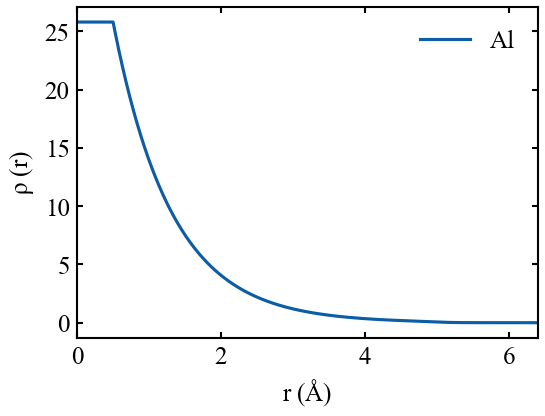

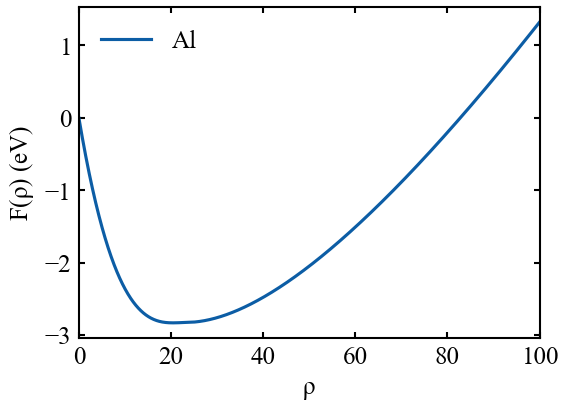

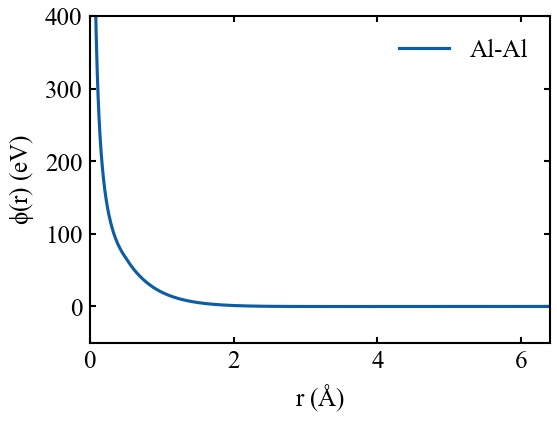

In [73]:
potential.plot()

#### 8.2 使用势函数计算Al的EOS曲线

In [74]:
energy = []
lattice_constant = 4.05
fcc = mp.LatticeMaker(lattice_constant, 'FCC', 1, 1, 1)
fcc.compute()
for scale in tqdm(np.arange(0.95, 1.06, 0.01)):
    Cal = mp.Calculator(potential, fcc.pos * scale, [1, 1, 1], fcc.box * scale, ['Al'], np.ones(fcc.N, int))
    Cal.compute()
    energy.append([lattice_constant*scale, Cal.energy.mean()])
energy = np.array(energy)

100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Text(0, 0.5, 'PE (eV/atom)')

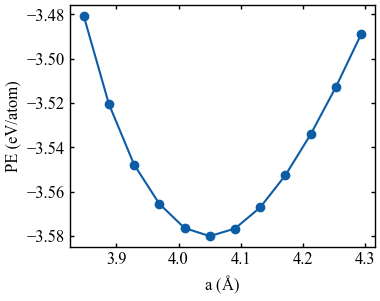

In [75]:
fig = plt.figure(figsize=(mp.cm2inch(10), mp.cm2inch(8)))
plt.plot(energy[:, 0], energy[:, 1], 'o-')
plt.xlabel('a ($\mathregular{\AA}$)')
plt.ylabel('PE (eV/atom)')

## <b> 9. 处理轨迹 </b>

- 读取rdf.0.dump 到rdf.4.dump

In [76]:
MS = mp.MultiSystem([f'traj/rdf.{i}.dump' for i in range(5)])

Reading traj/rdf.4.dump: 100%|██████████| 5/5 [00:00<00:00, 21.05it/s]


In [77]:
MS[0]

Filename: traj/rdf.0.dump
Atom Number: 15625
Simulation Box:
[[ 27.4946022   0.          0.       ]
 [  0.         27.4946022   0.       ]
 [  0.          0.         27.4946022]
 [-13.7473011 -13.7473011 -13.7473011]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (5, 5)
┌─────┬──────┬───────────┬───────────┬────────────┐
│ id  ┆ type ┆ x         ┆ y         ┆ z          │
│ --- ┆ ---  ┆ ---       ┆ ---       ┆ ---        │
│ i64 ┆ i64  ┆ f64       ┆ f64       ┆ f64        │
╞═════╪══════╪═══════════╪═══════════╪════════════╡
│ 1   ┆ 0    ┆ 10.01553  ┆ -4.348063 ┆ -6.279958  │
│ 2   ┆ 0    ┆ -5.159263 ┆ -6.642017 ┆ 1.14219    │
│ 3   ┆ 0    ┆ 0.46146   ┆ -6.818775 ┆ -12.233191 │
│ 4   ┆ 0    ┆ 6.030577  ┆ 9.578183  ┆ 4.405061   │
│ 5   ┆ 0    ┆ 8.068093  ┆ -5.647203 ┆ 9.575496   │
└─────┴──────┴───────────┴───────────┴────────────┘

- 计算MSD

In [78]:
MS.cal_mean_squared_displacement()

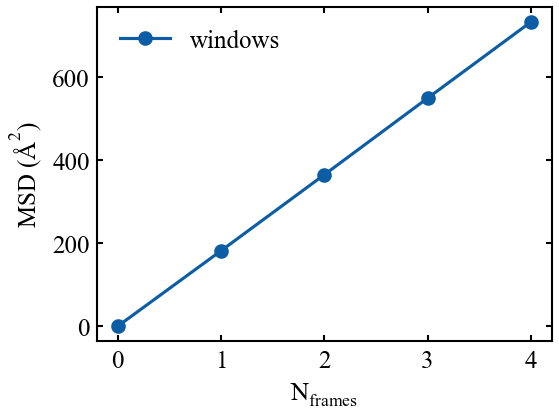

In [79]:
fig, ax = MS.MSD.plot()

- 计算Lindemannindex

In [80]:
MS.cal_lindemann_parameter()

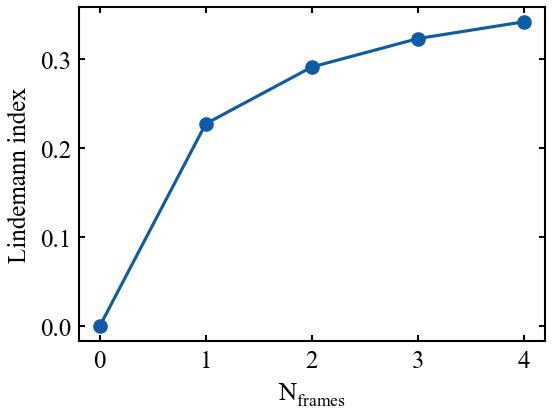

In [81]:
fig, ax = MS.Lindemann.plot()

In [82]:
MS[0]

Filename: traj/rdf.0.dump
Atom Number: 15625
Simulation Box:
[[ 27.4946022   0.          0.       ]
 [  0.         27.4946022   0.       ]
 [  0.          0.         27.4946022]
 [-13.7473011 -13.7473011 -13.7473011]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (5, 7)
┌─────┬──────┬───────────┬───────────┬────────────┬─────────────┬───────────┐
│ id  ┆ type ┆ x         ┆ y         ┆ z          ┆ msd         ┆ lindemann │
│ --- ┆ ---  ┆ ---       ┆ ---       ┆ ---        ┆ ---         ┆ ---       │
│ i64 ┆ i64  ┆ f64       ┆ f64       ┆ f64        ┆ f64         ┆ f64       │
╞═════╪══════╪═══════════╪═══════════╪════════════╪═════════════╪═══════════╡
│ 1   ┆ 0    ┆ 10.01553  ┆ -4.348063 ┆ -6.279958  ┆ 0.0         ┆ 0.0       │
│ 2   ┆ 0    ┆ -5.159263 ┆ -6.642017 ┆ 1.14219    ┆ -1.1369e-13 ┆ 0.0       │
│ 3   ┆ 0    ┆ 0.46146   ┆ -6.818775 ┆ -12.233191 ┆ 5.6843e-14  ┆ 0.0       │
│ 4   ┆ 0    ┆ 6.030577  ┆ 9.578183  ┆ 4.405061   ┆ -1.1369e-13 ┆ 0.0       │
│ 5   ┆ 0   

In [83]:
MS.write_dumps()

Saving traj/rdf.4.dump: 100%|██████████| 5/5 [00:00<00:00, 152.82it/s]
